# Projeto de Data Science aplicado à dataset do Airbnb Rio
## Objetivos: realizar uma análise exploratória dos dados e por fim tentar criar um modelo que determine o preço do imóvel
### Disclaimer: Será tomado como característica do nosso projeto a análise voltada a imóveis destinados ao brasileiro comum (imóveis considerados de luxo serão excluídos da análise)

## **1 Bibliotecas**

In [1]:
import pandas as pd # Manipulação de DataFrames e Series
import pathlib # Navegar entre pastas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### 1.1 Funções auxiliares

In [2]:
def limites(coluna):
    """
    Cálculo de limites inferior e superior para detecção de outliers
    """
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
    
def excluir_outliers(df, nome_coluna):
    """
    Exclusão de outliers de uma coluna de um DataFrame
    """
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

def diagrama_caixa(coluna, titulo, xlabel,fontsize_axis, fontsize_title, img_name=None):
    """
    Diagrama de caixa para visualização de outliers
    """
    if img_name is None:
        img_name = "box_"+titulo.replace(' ', '_')+".png"
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    fig.suptitle(titulo, fontsize=fontsize_title)
    ax1.set_xlabel(xlabel, fontsize=fontsize_axis)
    ax2.set_xlabel(xlabel, fontsize=fontsize_axis)
    ax1.set_title('Com outliers', fontsize=fontsize_title)
    ax2.set_title('Sem outliers', fontsize=fontsize_title)
    fig.savefig(img_name, transparent=True)
    plt.show()
    
def histograma(coluna, titulo, xlabel, ylabel, fontsize_axis, fontsize_title, img_name=None):
    """
    Histograma para visualização de distribuição de dados
    """
    if img_name is None:
        img_name = "hist_"+titulo.replace(' ', '_')+".png"
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    sns.distplot(coluna, hist=True, ax=ax)
    media=coluna.mean()
    ax.axvline(media, color='r', linestyle='--', linewidth=1, label='Média')
    plt.text(media, ax.get_ylim()[1]*0.9, f'Média = {media:.2f}', ha='center', va='center', color='r', rotation=0)
    ax.set_xlabel(xlabel, fontsize=fontsize_axis)
    ax.set_ylabel(ylabel, fontsize=fontsize_axis)
    ax.set_title(titulo, fontsize=fontsize_title)
    fig.savefig(img_name, transparent=True)
    plt.show()

def grafico_barra(coluna, titulo, xlabel, ylabel, fontsize_axis, fontsize_title, fontsize_x, rotation_x=0, quantidades=False, img_name=None):
    """
    Gráfico de barras para visualização de distribuição de dados
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    if img_name is None:
        img_name = "bar_"+titulo.replace(' ', '_')+".png"
    plot = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts(), ax=ax)
    ax.set_xlabel(xlabel, fontsize=fontsize_axis)
    ax.set_ylabel(ylabel, fontsize=fontsize_axis)
    ax.set_title(titulo, fontsize=fontsize_title)
    ax.tick_params(axis='x', rotation=rotation_x, labelsize=fontsize_x)
    qt_x = len(coluna.value_counts().index)
    if qt_x > 20:
        passo = int(np.ceil(qt_x / 20))
        ax.set_xticks(range(0, qt_x, passo))

    if quantidades:
        total = len(coluna)
        for bar in plot.patches:
            plot.annotate(f'{bar.get_height():.0f} ({(bar.get_height()/total)*100:.2f}%)',
                        (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                        size=8, xytext=(0, 8),
                        textcoords='offset points')
    fig.savefig(img_name, transparent=True)
    plt.show()

def agrupar_categorias(df, coluna, qtd_min_por_categoria):
    """
    Agrupamento de categorias com baixa frequência
    """
    categorias = df[coluna].value_counts()
    categoarias_a_agrupar = []

    for categoria in categorias.index:
        if categorias[categoria] < qtd_min_por_categoria:
            categoarias_a_agrupar.append(categoria)

    for categoria in categoarias_a_agrupar:
        df.loc[df[coluna]==categoria, coluna] = 'Outros'

    return df

def metricas_modelo(nome_modelo, y_teste, previsao):
    """
    Cálculo de métricas de avaliação de modelos de regressão
    """
    r2 = r2_score(y_teste, previsao)
    MSE = mean_squared_error(y_teste, previsao)
    MAE = mean_absolute_error(y_teste, previsao)
    return {nome_modelo: {
                          'CD':round(r2, 2),
                          'MSE':round(MSE, 2),
                          'MAE':round(MAE, 2)
                        }
            }

def treinar_modelos(X, y, modelos):
    """
    Treinamento de modelos de regressão
    """
    t0 = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    metricas_modelos = []

    for nome_modelo, modelo in modelos.items():
        if nome_modelo == 'SupportVectorMachines':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            modelo.fit(X_train_scaled, y_train)
            previsao = modelo.predict(X_test_scaled)
            metricas_modelos.append(metricas_modelo(nome_modelo, y_test, previsao))
        else:
            #treinar
            modelo.fit(X_train, y_train)
            #testar
            previsao = modelo.predict(X_test)
            metricas_modelos.append(metricas_modelo(nome_modelo, y_test, previsao))

    tf = time.time()

    print("Demorou", (round((tf-t0)/60, 2)), "minutos para treinar os modelos")

    return metricas_modelos

## **2 Importação das bases de dados**

### 2.1 Obtenção dos dados

In [3]:
t_o = time.time()

try:
    df_airbnb_listagens = pd.read_csv("http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2023-03-28/data/listings.csv.gz")
except:
    #Busca o arquivo no repositório do GitHub
    try:
        df_airbnb_listagens = pd.read_csv("https://raw.githubusercontent.com/Ciencia-de-Dados-IMT/Projeto-I/main/listings.csv.gz")
    except:
        df_airbnb_listagens = pd.read_csv("listings.csv.gz")
  
t_f = time.time()

print("Demorou", round(t_f-t_o, 2), "segundos para importar os dados")

Demorou 4.55 segundos para importar os dados


### 2.2 Visualização de quais dados estão disponíveis

In [4]:
print("Colunas disponíveis:")
for col in df_airbnb_listagens.columns:
    print(f'\t{col}')

Colunas disponíveis:
	id
	listing_url
	scrape_id
	last_scraped
	source
	name
	description
	neighborhood_overview
	picture_url
	host_id
	host_url
	host_name
	host_since
	host_location
	host_about
	host_response_time
	host_response_rate
	host_acceptance_rate
	host_is_superhost
	host_thumbnail_url
	host_picture_url
	host_neighbourhood
	host_listings_count
	host_total_listings_count
	host_verifications
	host_has_profile_pic
	host_identity_verified
	neighbourhood
	neighbourhood_cleansed
	neighbourhood_group_cleansed
	latitude
	longitude
	property_type
	room_type
	accommodates
	bathrooms
	bathrooms_text
	bedrooms
	beds
	amenities
	price
	minimum_nights
	maximum_nights
	minimum_minimum_nights
	maximum_minimum_nights
	minimum_maximum_nights
	maximum_maximum_nights
	minimum_nights_avg_ntm
	maximum_nights_avg_ntm
	calendar_updated
	has_availability
	availability_30
	availability_60
	availability_90
	availability_365
	calendar_last_scraped
	number_of_reviews
	number_of_reviews_ltm
	number_of_revi

## **3 Tratar os Dados (Análise Qualitativa)**

1.   Excluir informações não relevantes  
2.   Excluir colunas repetidas ou extremamente parecidadas com outra
3.   Excluir colunas preenchidas com texto livre
4.   Excluir colunas com todos os valores iguais


### 3.1 Excluir informações não relevantes

Para isso, vamos criar um arquivo em excel com os 100 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [5]:
df_airbnb_listagens.head(100).to_csv('primeiros_registros.csv', sep=';')

Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima (item 3), ficamos com as seguintes colunas:




In [6]:
# colunas armazena a lista com as colunas que restarão
colunas = ['host_response_time', 'host_response_rate', 
           'host_acceptance_rate', 'host_is_superhost', 
           'neighbourhood_cleansed', 'latitude', 
           'longitude', 'property_type', 
           'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 
           'price', 'minimum_nights', 'availability_365', 'number_of_reviews', 
           'review_scores_rating', 'instant_bookable', 
           'calculated_host_listings_count']


df_airbnb_listagens = df_airbnb_listagens.loc[:, colunas]
print(f'Dimensões do DataFrame: {df_airbnb_listagens.shape}')

Dimensões do DataFrame: (30476, 20)


### 3.2 Tratar valores vazios

In [7]:
# Mostra a quantidade valores vazios por coluna
print(df_airbnb_listagens.isnull().sum()) 

host_response_time                4695
host_response_rate                4695
host_acceptance_rate              3733
host_is_superhost                    7
neighbourhood_cleansed               0
latitude                             0
longitude                            0
property_type                        0
room_type                            0
accommodates                         0
bathrooms_text                      41
bedrooms                          1305
beds                               218
price                                0
minimum_nights                       0
availability_365                     0
number_of_reviews                    0
review_scores_rating              7504
instant_bookable                     0
calculated_host_listings_count       0
dtype: int64


Se houver mais de 7.500 linhas (Aproximadamente, 1/4 do total de linhas) vazias na coluna, exclui-se a coluna. Pode se tratar de um dado inconsistente.


In [8]:
for coluna in df_airbnb_listagens:
    if df_airbnb_listagens[coluna].isnull().sum() > 7500:
        df_airbnb_listagens = df_airbnb_listagens.drop(coluna, axis=1)

print("Colunas removidas:")
for col in colunas:
    if col not in df_airbnb_listagens.columns:
        print(f'\t{col}')

Colunas removidas:
	review_scores_rating


Excluindo linhas com valores vazios para qualquer coluna

In [9]:
nlinhas_i = df_airbnb_listagens.shape[0]
df_airbnb_listagens = df_airbnb_listagens.dropna()
nlinhas_f = df_airbnb_listagens.shape[0]

print(f'Número de linhas removidas: {nlinhas_i - nlinhas_f}')
print(f'Dimensões do DataFrame: {df_airbnb_listagens.shape}')

Número de linhas removidas: 6781
Dimensões do DataFrame: (23695, 19)


### 3.3 Verificar Tipos de Dados em cada coluna
- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [10]:
print(df_airbnb_listagens.dtypes)
print('-'*60)
print(df_airbnb_listagens.iloc[0])

host_response_time                 object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
neighbourhood_cleansed             object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
price                              object
minimum_nights                      int64
availability_365                    int64
number_of_reviews                   int64
instant_bookable                   object
calculated_host_listings_count      int64
dtype: object
------------------------------------------------------------
host_response_time                 within an hour
host_response_rate                           100%
host_acceptance_rate       

Como o preço está identificado como objeto, devemos tratá-lo para transformar em float.

In [11]:
#price
df_airbnb_listagens['price'] = df_airbnb_listagens['price'].str.replace('$', '')
df_airbnb_listagens['price'] = df_airbnb_listagens['price'].str.replace(',', '')
df_airbnb_listagens['price'] = df_airbnb_listagens['price'].astype(np.float64, copy=False)
print(df_airbnb_listagens.dtypes)

host_response_time                 object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
neighbourhood_cleansed             object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
price                             float64
minimum_nights                      int64
availability_365                    int64
number_of_reviews                   int64
instant_bookable                   object
calculated_host_listings_count      int64
dtype: object


## **4 Análise Exploratória e Tratar Outliers**


- Vamos basicamente olhar feature por feature para:
    1. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    2. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    3. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

Correlação negativa: grandezas inversamente proporcionais
Correlação positiva: grandezas diretamente proporcionais

### 4.1 Tratamento de valores numéricos

#### 4.1.1 price

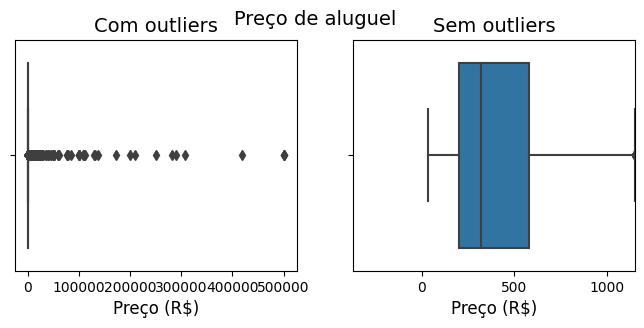

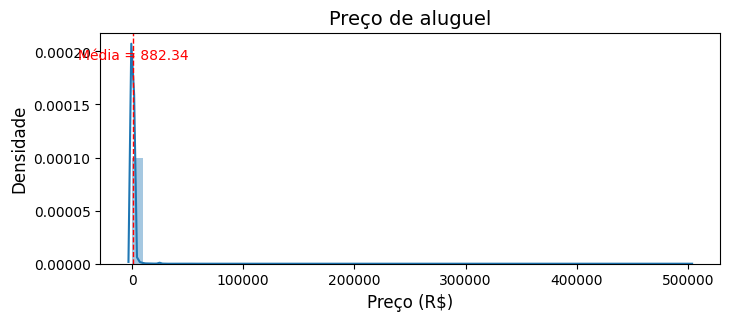

In [12]:
diagrama_caixa(df_airbnb_listagens['price'], 'Preço de aluguel', 'Preço (R$)', 12, 14)
histograma(df_airbnb_listagens['price'], 'Preço de aluguel', 'Preço (R$)', 'Densidade', 12, 14)

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [13]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'price')
print('{} linhas removidas'.format(linhas_removidas))

2152 linhas removidas


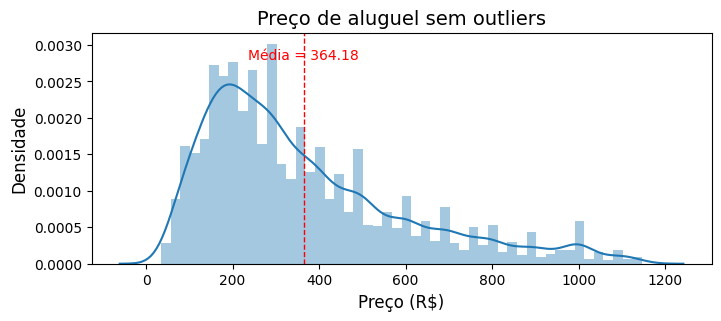

In [14]:
histograma(df_airbnb_listagens['price'], 'Preço de aluguel sem outliers', 'Preço (R$)', 'Densidade', 12, 14)

#### 4.1.2 calculated_host_listings_count

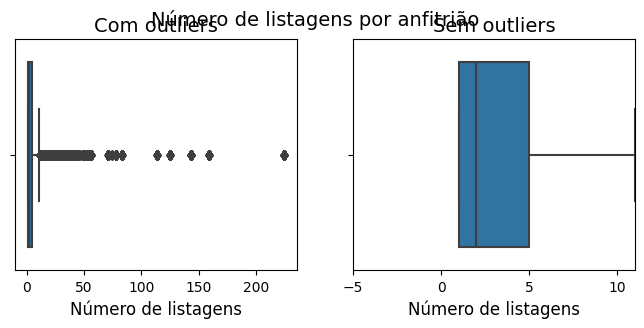

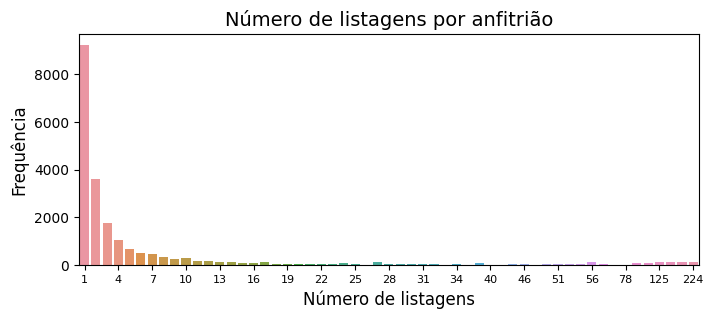

In [15]:
diagrama_caixa(df_airbnb_listagens['calculated_host_listings_count'], 'Número de listagens por anfitrião', 'Número de listagens', 12, 14)
grafico_barra(df_airbnb_listagens['calculated_host_listings_count'], 'Número de listagens por anfitrião', 'Número de listagens', 'Frequência', 12, 14, 8)

Podemos excluir os outliers, porque para o objetivo do nosso projeto hosts com mais de 12 imóveis no airbnb não é o público alvo do objetivo (talvez sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [16]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'calculated_host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

3165 linhas removidas


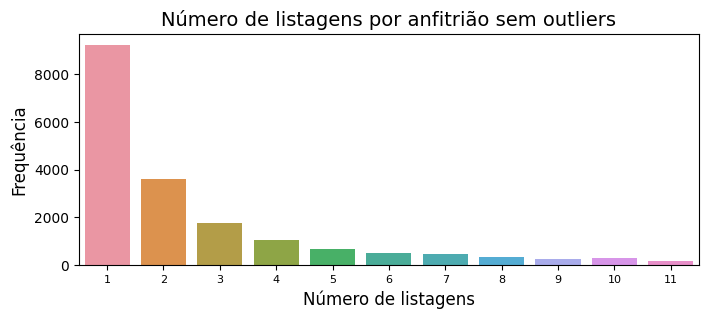

In [17]:
grafico_barra(df_airbnb_listagens['calculated_host_listings_count'], 'Número de listagens por anfitrião sem outliers', 'Número de listagens', 'Frequência', 12, 14, 8)

#### 4.1.3 minimum_nights

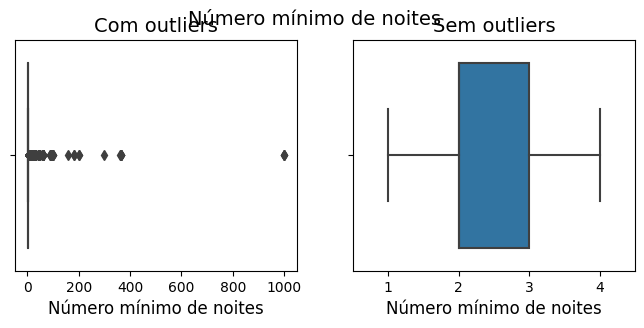

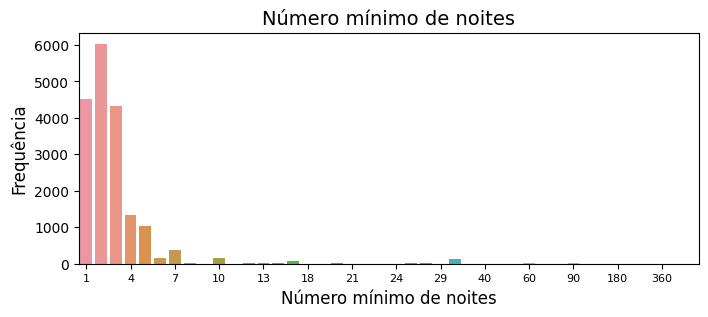

In [18]:
diagrama_caixa(df_airbnb_listagens['minimum_nights'], 'Número mínimo de noites', 'Número mínimo de noites', 12, 14)
grafico_barra(df_airbnb_listagens['minimum_nights'], 'Número mínimo de noites', 'Número mínimo de noites', 'Frequência', 12, 14, 8)

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo dados de apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [19]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

2142 linhas removidas


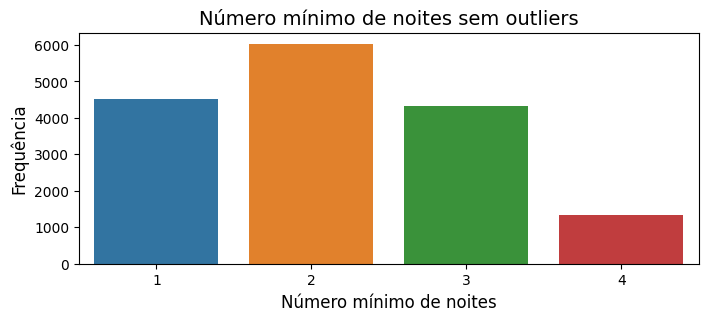

In [20]:
grafico_barra(df_airbnb_listagens['minimum_nights'], 'Número mínimo de noites sem outliers', 'Número mínimo de noites', 'Frequência', 12, 14, 10)

#### 4.1.4 number_of_reviews

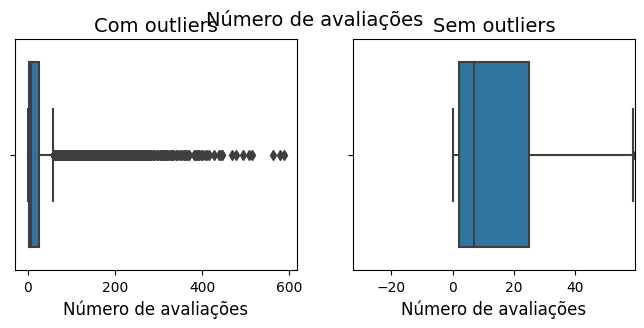

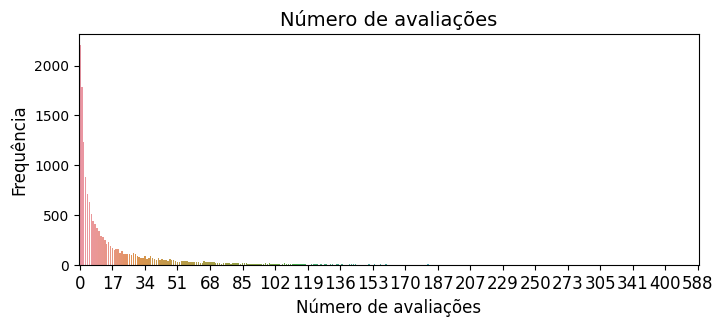

In [21]:
diagrama_caixa(df_airbnb_listagens['number_of_reviews'], 'Número de avaliações', 'Número de avaliações', 12, 14)
grafico_barra(df_airbnb_listagens['number_of_reviews'], 'Número de avaliações', 'Número de avaliações', 'Frequência', 12, 14, 12)

- Aqui poderíamos tomar algumas decisões diferentes. Vamos uma decisão baseado na análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se excluirmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no nosso objetivo, se temos um imóvel parado e queremos colocar nosso imóvel no airbnb, é claro que eu não teremos review nenhuma inicialmente. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.

In [22]:
df_airbnb_listagens = df_airbnb_listagens.drop('number_of_reviews', axis=1)

#### 4.1.5 accommodates

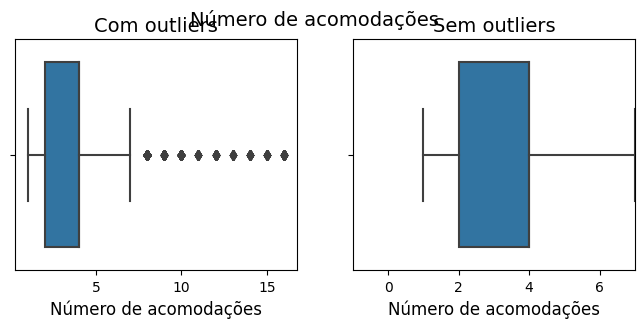

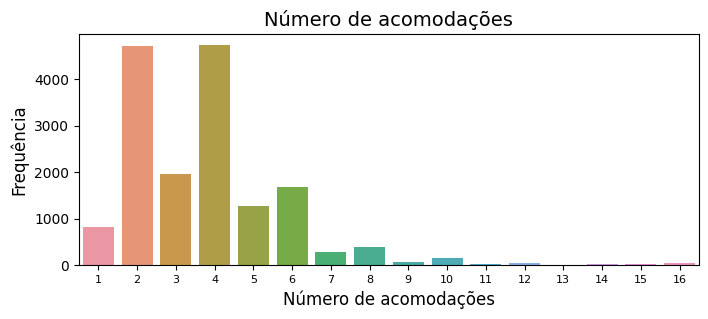

In [23]:
diagrama_caixa(df_airbnb_listagens['accommodates'], 'Número de acomodações', 'Número de acomodações', 12, 14)
grafico_barra(df_airbnb_listagens['accommodates'], 'Número de acomodações', 'Número de acomodações', 'Frequência', 12, 14, 8)

Pelo mesmo motivo do "calculated_host_listings_count" vamos excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

Caso quiséssemos incluir apartamentos de alto padrão a poderiamos manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [24]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

774 linhas removidas


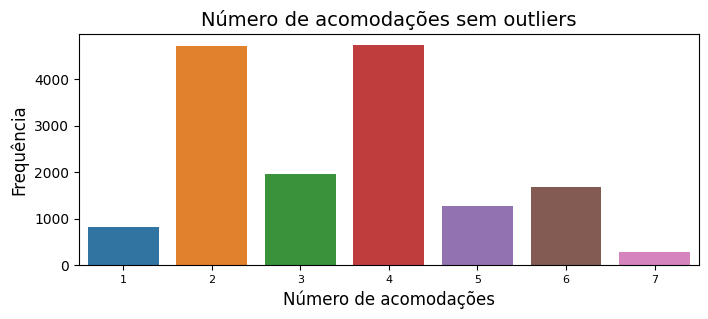

In [25]:
grafico_barra(df_airbnb_listagens['accommodates'], 'Número de acomodações sem outliers', 'Número de acomodações', 'Frequência', 12, 14, 8)

### 4.2 Tratamento de Colunas de Valores de Texto

#### 4.2.1 bathrooms_text

In [26]:
print(df_airbnb_listagens['bathrooms_text'].value_counts())
print(len(df_airbnb_listagens['bathrooms_text'].value_counts()))

1 bath               7106
2 baths              2726
1 shared bath        1646
1 private bath       1295
1.5 baths             888
3 baths               473
2.5 baths             391
2 shared baths        321
1.5 shared baths      315
3.5 baths              71
3 shared baths         53
2.5 shared baths       48
4 baths                39
Shared half-bath       12
4 shared baths         12
3.5 shared baths       11
4.5 baths               9
5 baths                 8
0 baths                 7
0 shared baths          7
5 shared baths          5
6 shared baths          4
Half-bath               3
6.5 shared baths        2
7 shared baths          2
4.5 shared baths        2
8 baths                 1
5.5 baths               1
16 baths                1
8 shared baths          1
Private half-bath       1
7 baths                 1
Name: bathrooms_text, dtype: int64
32


Vamos tratar os dados manualmente, dado que não são muitos valores

In [27]:
df_airbnb_listagens['bathrooms_text'].unique()

array(['1 bath', '2 baths', '1.5 baths', '2.5 baths', '1 shared bath',
       '1 private bath', '3 baths', '1.5 shared baths', '5 shared baths',
       '2 shared baths', '0 shared baths', '5 baths', '2.5 shared baths',
       'Shared half-bath', '3.5 baths', '3 shared baths', '4 baths',
       '3.5 shared baths', '4.5 baths', '8 baths', '6.5 shared baths',
       '5.5 baths', '0 baths', '7 shared baths', '4 shared baths',
       '6 shared baths', '16 baths', 'Half-bath', '4.5 shared baths',
       '8 shared baths', 'Private half-bath', '7 baths'], dtype=object)

In [28]:
mapa_num_banheiros = {
    '1 bath': 1,
    '2 baths': 2, 
    '1.5 baths': 2, 
    '2.5 baths': 3, 
    '1 shared bath': 1,
    '1 private bath': 1, 
    '3 baths': 3, 
    '1.5 shared baths': 2, 
    '5 shared baths': 5,
    '2 shared baths': 2, 
    '0 shared baths': 0, 
    '5 baths': 5, 
    '2.5 shared baths': 3,
    'Shared half-bath': 1, 
    '3.5 baths': 4, 
    '3 shared baths': 3, 
    '4 baths': 4,
    '3.5 shared baths': 4, 
    '4.5 baths': 5, 
    '8 baths': 8, 
    '6.5 shared baths': 7,
    '5.5 baths': 6, 
    '0 baths': 0, 
    '7 shared baths': 7, 
    '4 shared baths': 4,
    '6 shared baths': 6, 
    '16 baths': 16, 
    'Half-bath': 1, 
    '4.5 shared baths': 5,
    '8 shared baths': 8, 
    'Private half-bath': 1, 
    '7 baths': 7
}

In [29]:
for mapa in mapa_num_banheiros:
    df_airbnb_listagens.loc[df_airbnb_listagens['bathrooms_text'] == mapa, 'bathrooms_text'] = mapa_num_banheiros[mapa]

df_airbnb_listagens = df_airbnb_listagens.rename(columns={'bathrooms_text': 'bathrooms'})

Agora temos valores inteiros definindo a quantidade de banheiros do local

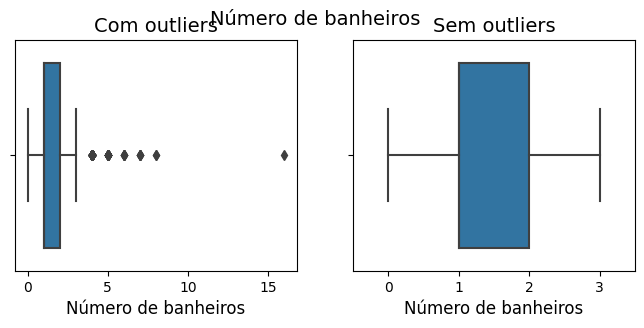

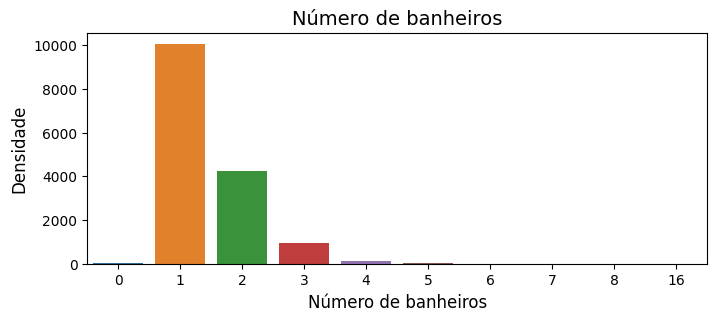

In [30]:
diagrama_caixa(df_airbnb_listagens['bathrooms'], 'Número de banheiros', 'Número de banheiros', 12, 14)
grafico_barra(df_airbnb_listagens['bathrooms'], 'Número de banheiros', 'Número de banheiros', 'Densidade', 12, 14, 10)

Como casas com mais de 3 banheiros já são consideradas como de luxo - categoria fora do nosso escopo - iremos excluir os outliers

In [31]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

170 linhas removidas


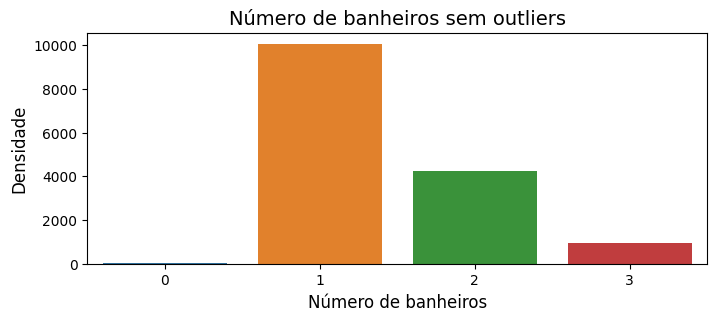

In [32]:
grafico_barra(df_airbnb_listagens['bathrooms'], 'Número de banheiros sem outliers', 'Número de banheiros', 'Densidade', 12, 14, 10)

#### 4.2.2 property_type

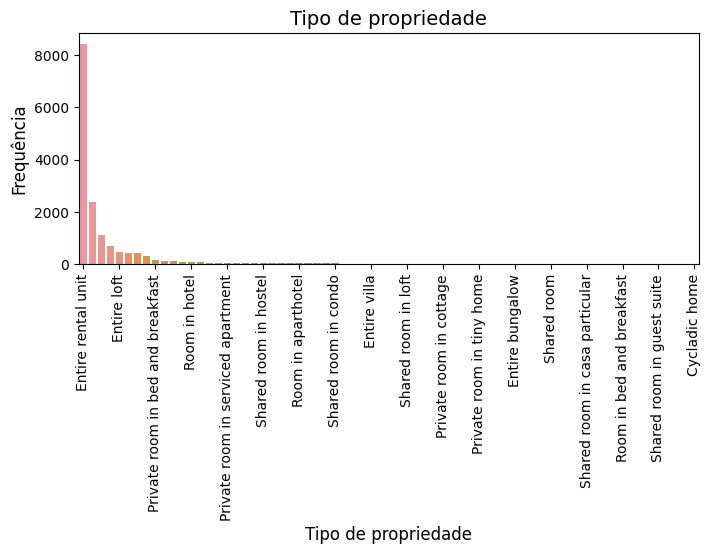

In [33]:
grafico_barra(df_airbnb_listagens['property_type'], 'Tipo de propriedade', 'Tipo de propriedade', 'Frequência', 12, 14, 10, 90)

Aqui a nossa ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

Todos os tipos de propriedade que têm menos de 500 propriedades na base de dados, vamos agrupar em um grupo chamado "outros". Isso vai facilitar o nosso modelo

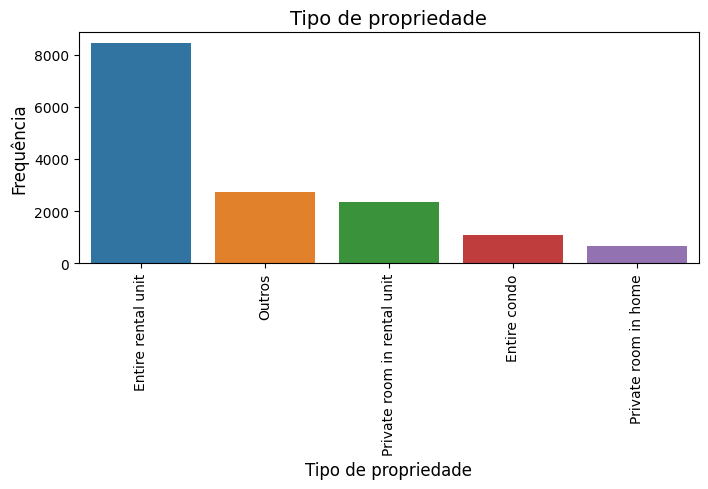

In [34]:
df_airbnb_listagens = agrupar_categorias(df_airbnb_listagens, 'property_type', 500)

grafico_barra(df_airbnb_listagens['property_type'], 'Tipo de propriedade', 'Tipo de propriedade', 'Frequência', 12, 14, 10, 90)

#### 4.2.3 room_type

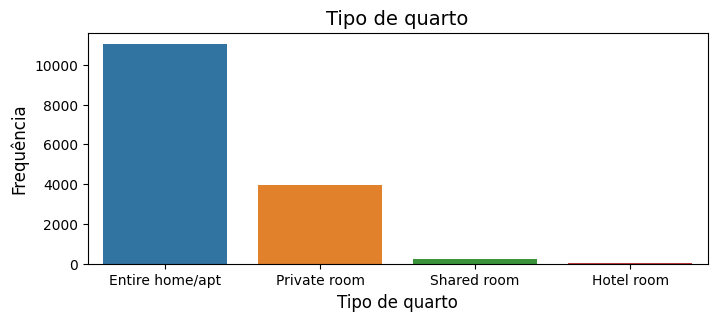

In [35]:
grafico_barra(df_airbnb_listagens['room_type'], 'Tipo de quarto', 'Tipo de quarto', 'Frequência', 12, 14, 10)

Em tipo de quarto, não precisamos fazer nada, já parece estar bem distribuído

#### 4.2.4 host_response_time

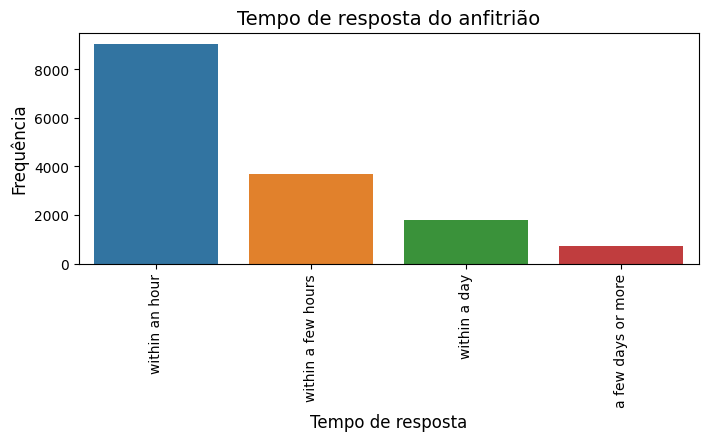

In [36]:
grafico_barra(df_airbnb_listagens['host_response_time'], 'Tempo de resposta do anfitrião', 'Tempo de resposta', 'Frequência', 12, 14, 10, 90)

O tempo de resposta do host é dividido em 4 categorias. Como não são muitas, não precisa haver agrupamento

#### 4.2.5 neighbourhood_cleansed

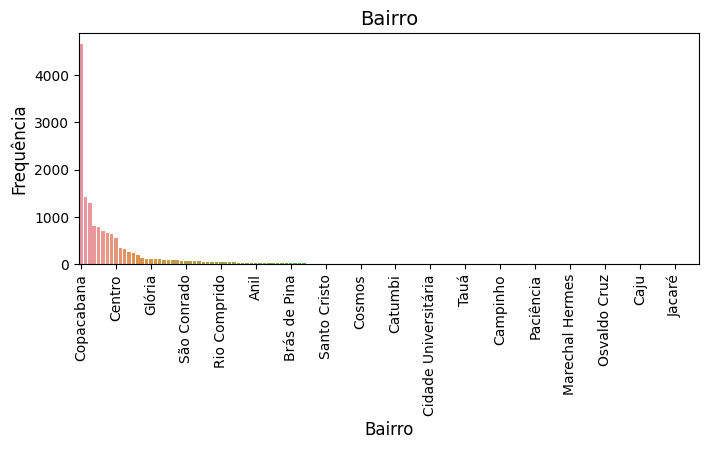

In [37]:
grafico_barra(df_airbnb_listagens['neighbourhood_cleansed'], 'Bairro', 'Bairro', 'Frequência', 12, 14, 10, 90)

Como são muitas "Vizinhanças", conjuntos com quantidades inferiores a 250 serão agrupados em "Outros"

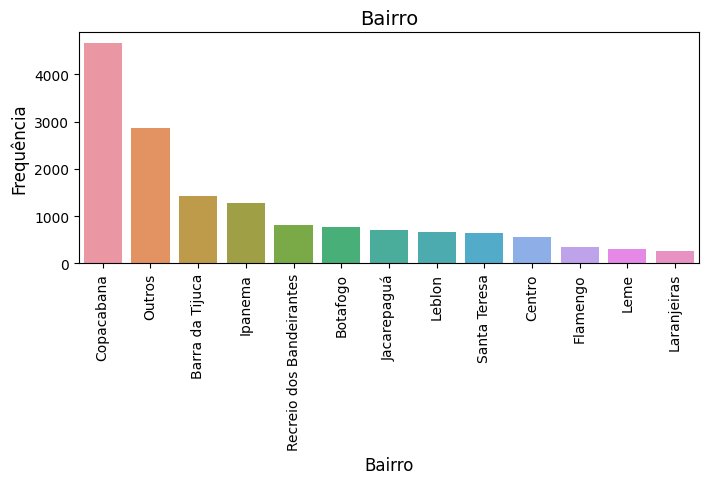

In [38]:
df_airbnb_listagens = agrupar_categorias(df_airbnb_listagens, 'neighbourhood_cleansed', 250)

grafico_barra(df_airbnb_listagens['neighbourhood_cleansed'], 'Bairro', 'Bairro', 'Frequência', 12, 14, 10, 90)

#### 4.2.6 host_response_rate e host_acceptance_rate

Ambas as colunas finalizadas em __rate_ estão em porcentagem. É necessário trsnformá-las em float

In [39]:
df_airbnb_listagens['host_response_rate'] = df_airbnb_listagens['host_response_rate'].str.replace('%', '')
df_airbnb_listagens['host_response_rate'] = df_airbnb_listagens['host_response_rate'].str.replace(',', '.')
df_airbnb_listagens['host_response_rate'] = df_airbnb_listagens['host_response_rate'].astype(np.float64, copy=False)
df_airbnb_listagens['host_response_rate'] = df_airbnb_listagens['host_response_rate'] / 100

In [40]:
df_airbnb_listagens['host_acceptance_rate'] = df_airbnb_listagens['host_acceptance_rate'].str.replace('%', '')
df_airbnb_listagens['host_acceptance_rate'] = df_airbnb_listagens['host_acceptance_rate'].str.replace(',', '.')
df_airbnb_listagens['host_acceptance_rate'] = df_airbnb_listagens['host_acceptance_rate'].astype(np.float64, copy=False)
df_airbnb_listagens['host_acceptance_rate'] = df_airbnb_listagens['host_acceptance_rate'] / 100

### 4.3 Visualização da correlação entre as variáveis numéricas

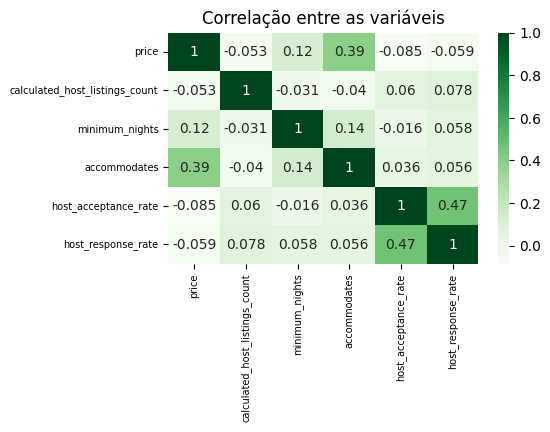

In [41]:
# Mapa de calor ainda ajuda a confirmar se há duas colunas iguais visto que só pode haver 1 na diagonal principal da matriz (Teria algum 1 aleatório no mapa)

plt.figure(figsize=(5, 3))
dfcor = df_airbnb_listagens[['price', 'calculated_host_listings_count', 
                            'minimum_nights', 'bathrooms', 'accommodates', 
                            'host_acceptance_rate', 'host_response_rate']]

hmap = sns.heatmap(dfcor.corr(), annot=True, cmap='Greens')
hmap.set_title('Correlação entre as variáveis')
hmap.tick_params(axis="both", labelsize=7)
plt.show()

Podemos notar que não há correlações próximas a 1 (exceto na diagonal principal), o que demonstra qua não existem variáveis com o mesmo valor, porém nomes diferentes.<br>
Dessa forma, não precisamos excluir nenhuma coluna.

## **5 Encoding**


Precisamor Ajustar as features para facilitar as análises futuras (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

**Criar Variáveis Dummies (Transformar textos em números)**

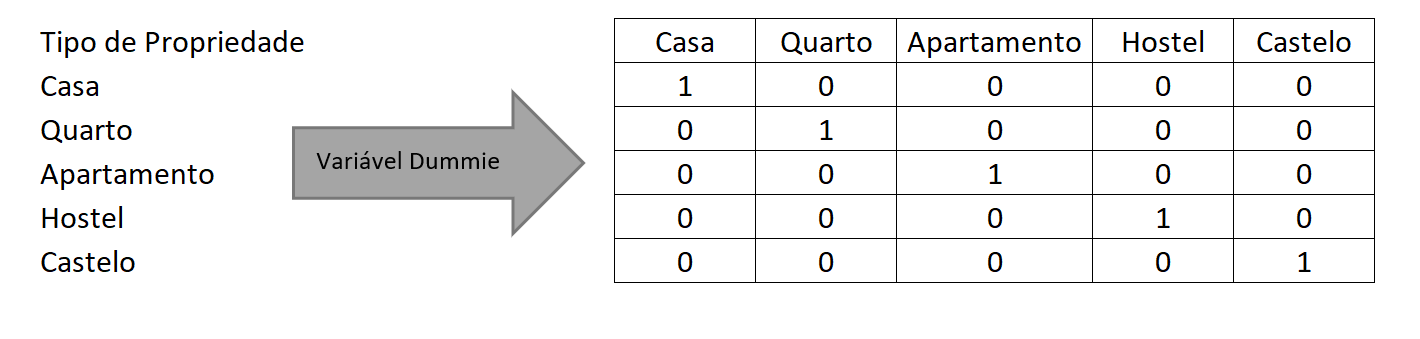

In [42]:
# Variável Dummie
colunas_categorias = ['property_type', 'room_type','host_response_time', 'neighbourhood_cleansed']
base_airbnb_listagens_cod = df_airbnb_listagens.copy()
base_airbnb_listagens_cod = pd.get_dummies(data=base_airbnb_listagens_cod, columns=colunas_categorias)
display(base_airbnb_listagens_cod.head())

,host_response_rate,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,neighbourhood_cleansed_Copacabana,neighbourhood_cleansed_Flamengo,neighbourhood_cleansed_Ipanema,neighbourhood_cleansed_Jacarepaguá,neighbourhood_cleansed_Laranjeiras,neighbourhood_cleansed_Leblon,neighbourhood_cleansed_Leme,neighbourhood_cleansed_Outros,neighbourhood_cleansed_Recreio dos Bandeirantes,neighbourhood_cleansed_Santa Teresa
2,1.0,0.89,f,-22.96582,-43.17786,2,1,1.0,1.0,266.0,...,1,0,0,0,0,0,0,0,0,0
3,1.0,0.33,f,-22.98405,-43.20189,2,1,1.0,1.0,624.0,...,0,0,1,0,0,0,0,0,0,0
5,1.0,0.86,t,-22.96392,-43.17263,2,1,1.0,2.0,236.0,...,0,0,0,0,0,0,1,0,0,0
6,1.0,0.58,f,-22.97735,-43.19105,3,1,1.0,1.0,307.0,...,1,0,0,0,0,0,0,0,0,0
7,1.0,0.75,f,-23.00980,-43.37099,4,2,2.0,2.0,539.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Colunas verdadeiros e falsos -> 1 e 0
colunas_tf = ['host_is_superhost', 'instant_bookable']
for coluna in colunas_tf:
  base_airbnb_listagens_cod.loc[base_airbnb_listagens_cod[coluna]=='t', coluna] = 1
  base_airbnb_listagens_cod.loc[base_airbnb_listagens_cod[coluna]=='f', coluna] = 0
display(base_airbnb_listagens_cod.head())

,host_response_rate,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,neighbourhood_cleansed_Copacabana,neighbourhood_cleansed_Flamengo,neighbourhood_cleansed_Ipanema,neighbourhood_cleansed_Jacarepaguá,neighbourhood_cleansed_Laranjeiras,neighbourhood_cleansed_Leblon,neighbourhood_cleansed_Leme,neighbourhood_cleansed_Outros,neighbourhood_cleansed_Recreio dos Bandeirantes,neighbourhood_cleansed_Santa Teresa
2,1.0,0.89,0,-22.96582,-43.17786,2,1,1.0,1.0,266.0,...,1,0,0,0,0,0,0,0,0,0
3,1.0,0.33,0,-22.98405,-43.20189,2,1,1.0,1.0,624.0,...,0,0,1,0,0,0,0,0,0,0
5,1.0,0.86,1,-22.96392,-43.17263,2,1,1.0,2.0,236.0,...,0,0,0,0,0,0,1,0,0,0
6,1.0,0.58,0,-22.97735,-43.19105,3,1,1.0,1.0,307.0,...,1,0,0,0,0,0,0,0,0,0
7,1.0,0.75,0,-23.00980,-43.37099,4,2,2.0,2.0,539.0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
print(base_airbnb_listagens_cod.dtypes)
print('-'*60)
print(base_airbnb_listagens_cod.iloc[0])

host_response_rate                                 float64
host_acceptance_rate                               float64
host_is_superhost                                   object
latitude                                           float64
longitude                                          float64
accommodates                                         int64
bathrooms                                           object
bedrooms                                           float64
beds                                               float64
price                                              float64
minimum_nights                                       int64
availability_365                                     int64
instant_bookable                                    object
calculated_host_listings_count                       int64
property_type_Entire condo                           uint8
property_type_Entire rental unit                     uint8
property_type_Outros                                 uin

## **6 Visualização dos dados**

### 6.1 Visualização de Mapa das Propriedades e Seus Preços

Vamos criar um mapa que exibe nossa base de dados (tratada) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [45]:
centro_mapa = {'lat':df_airbnb_listagens.latitude.mean(), 'lon':df_airbnb_listagens.longitude.mean()}
mapa = px.density_mapbox(base_airbnb_listagens_cod, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain',
                        title='Preço de aluguel por localização',
                        color_continuous_scale='viridis')
mapa.show()

É possível observar que as propriedades se concentram, principalmente, na região litorânea do Rio de Janeiro - onde também é realizado a prática dos maiores preços de aluguél dos imóveis analisados.

### 6.2 Distribuição de preços

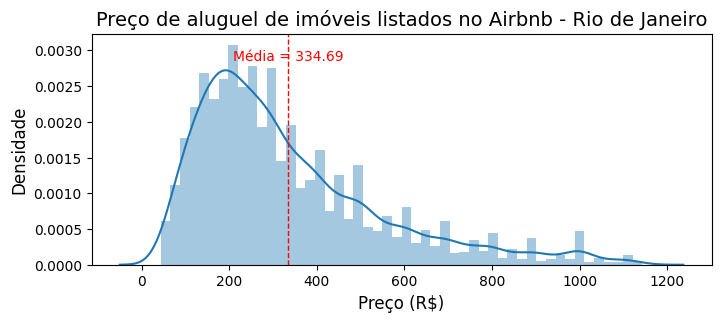

Quantidade de listagens: 15292
Número de listagens abaixo da média: 9410 (61.54%)


In [46]:
histograma(base_airbnb_listagens_cod['price'], 'Preço de aluguel de imóveis listados no Airbnb - Rio de Janeiro', 'Preço (R$)', 'Densidade', 12, 14)
n_t = len(base_airbnb_listagens_cod)
print(f'Quantidade de listagens: {n_t}')

n_1 = len(base_airbnb_listagens_cod[base_airbnb_listagens_cod["price"] < base_airbnb_listagens_cod["price"].mean()])
print(f'Número de listagens abaixo da média: {n_1} ({n_1/n_t*100:.2f}%)')

A distribuição de preço das 15292 listagens segue, conforme o histograma demonstrado, uma distribuição do tipo lognormal, concentrando a maior parte das listagens com preço abaixo da média geral (61,54%).

### 6.3 Quantidade de listagens do host

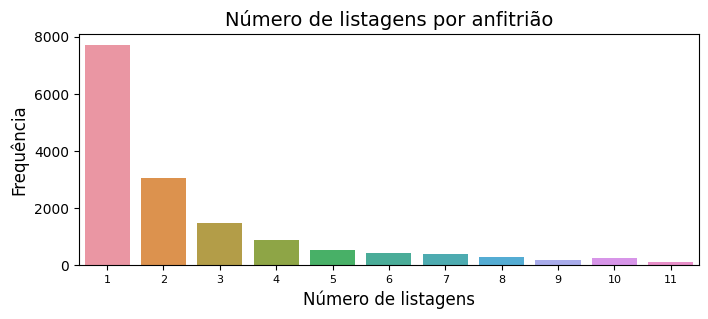

In [47]:
grafico_barra(base_airbnb_listagens_cod['calculated_host_listings_count'], 'Número de listagens por anfitrião', 'Número de listagens', 'Frequência', 12, 14, 8)

A distribuição da quantidade de listagens de cada host segue a distribuição esperada pelo grupo, com a maior quantidade de hosts possuindo apenas uma listagem. Afinal, como toda a análise é fundamentada em imóveis "comuns" para o brasileiro "comum", é muito difícil alguém de classe média possuir mais de 1 ou 2 propriedades.

As listagens onde o host possui mais de 1 anúncio podem ser de empresas, grupos hoteleiros ou condomínios de temporada.

Observação: Nesse caso não é usado o histograma para representação dos dados pois o número de listagens não é um valor numérico contínuo (não é possível ter 2.3 listagens, por exemplo)

### 6.4 Quantidade mínima de noites dos anúncios

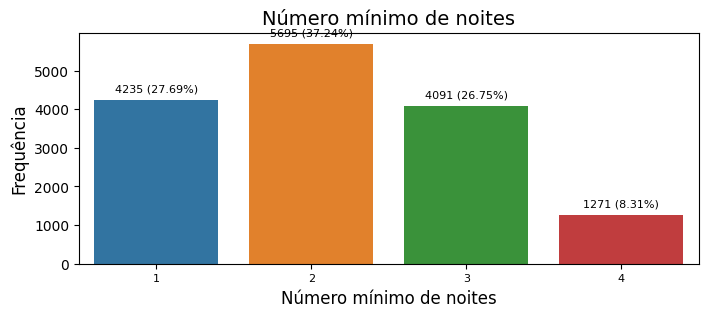

In [48]:
grafico_barra(base_airbnb_listagens_cod['minimum_nights'], 'Número mínimo de noites', 'Número mínimo de noites', 'Frequência', 12, 14, 8, 0, True)

A distribuição do número mínimo de noites que o cliente deve reservar no imóvel é bem definida e com intervalo não muito grande. Com pacotes variando de 1 a 4 dias, as listagens se concentram mais na faixa de 2 noites requeridas como mínimo de agendamento para disponibilizar o imóvel, já anúncios que requerem 1 ou 3 noites possuem uma quantidade quase igual de anúncios (4235 e 4091 anúncios respectivamente).

### 6.5 Número de pessoas que o imóvel acomoda

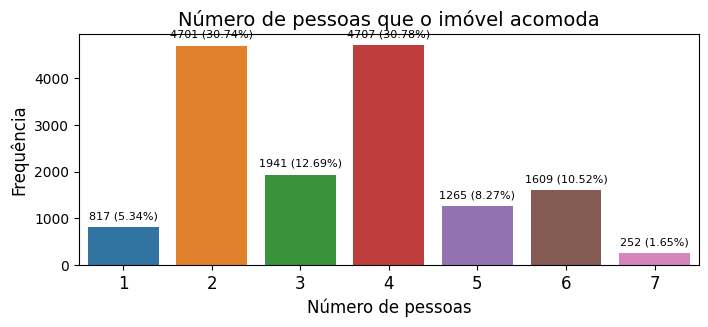

In [49]:
grafico_barra(base_airbnb_listagens_cod['accommodates'], 'Número de pessoas que o imóvel acomoda', 'Número de pessoas', 'Frequência', 12, 14, 12, 0, True)



Os imóveis são focados em atender 2 ou 4 pessoas (quantidades praticamente idênticas), ou seja, geralmente são focados em casais e famílisas médias (casal + 2 filhos).

Anúncios que comportam 6 ou mais pessoas possuem número menor dado de nossa análise é focada em imóveis comuns, que geralmente não comportam essa quantidade de pessoas.

### 6.6 Quantidade de banheiros no imóvel

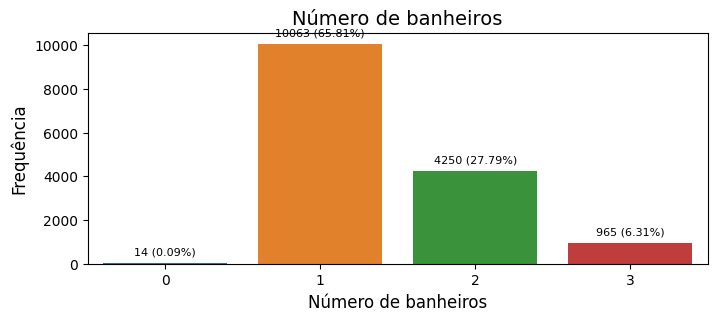

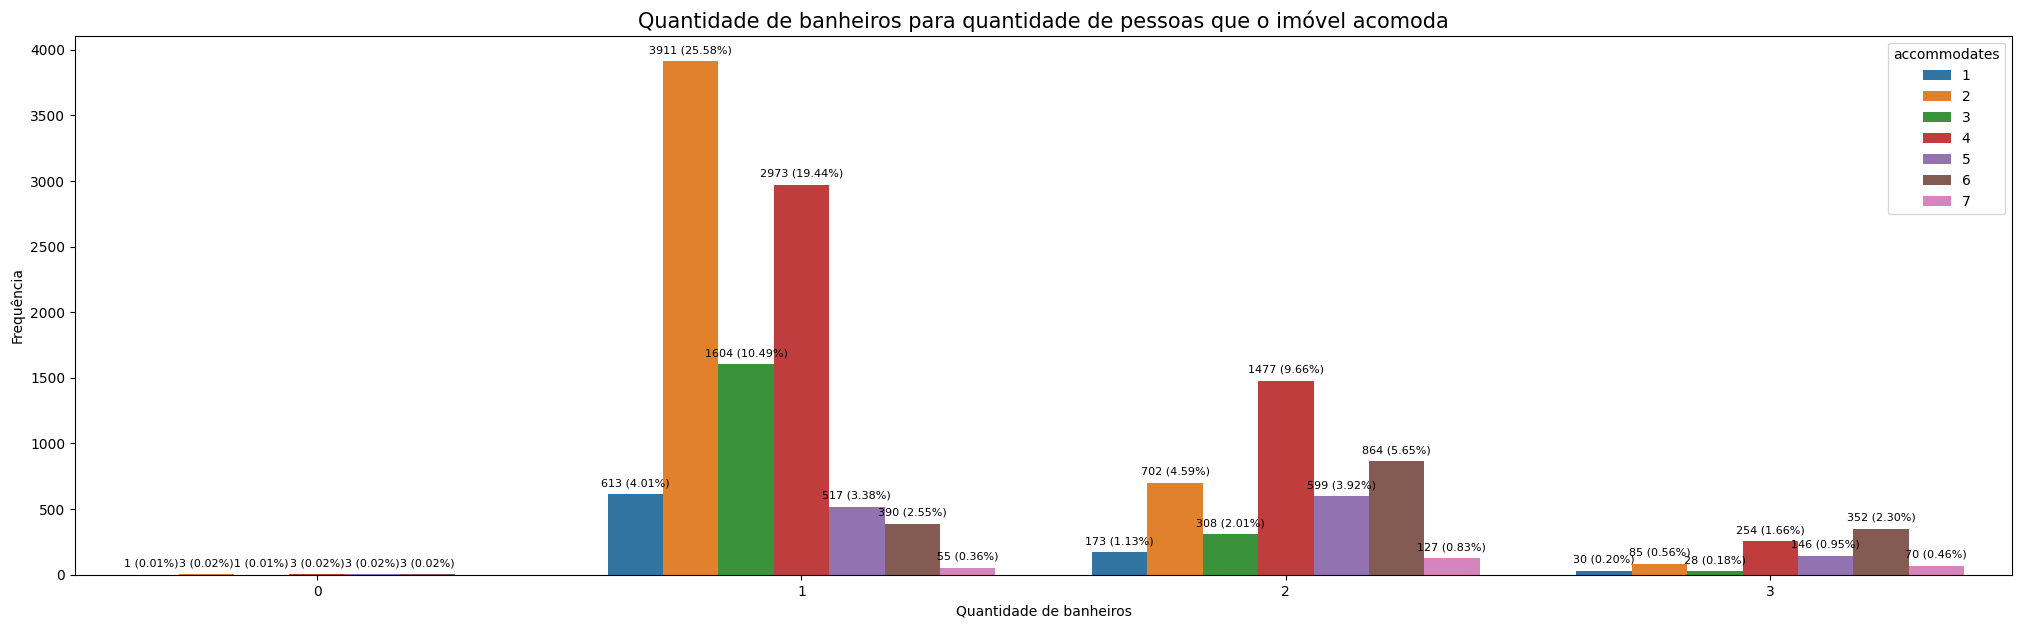

In [50]:
grafico_barra(base_airbnb_listagens_cod['bathrooms'], 'Número de banheiros', 'Número de banheiros', 'Frequência', 12, 14, 10, 0, True)

fig, ax = plt.subplots(1, 1, figsize=(25, 7))

df_temp = base_airbnb_listagens_cod[['bathrooms', 'accommodates']]

ocorrencias = df_temp.groupby(['bathrooms', 'accommodates']).size().reset_index(name='count')

plot = sns.barplot(x='bathrooms', y='count', hue='accommodates', data=ocorrencias, ax=ax)
ax.set_xlabel('Quantidade de banheiros', fontsize=10)
ax.set_ylabel('Frequência', fontsize=10)
ax.set_title('Quantidade de banheiros para quantidade de pessoas que o imóvel acomoda', fontsize=15)
ax.tick_params(axis='x', rotation=0, labelsize=10)
total = len(df_temp)
for bar in plot.patches:
    plot.annotate(f'{bar.get_height():.0f} ({(bar.get_height()/total)*100:.2f}%)',
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                size=8, xytext=(0, 8),
                textcoords='offset points')
plt.show()


Com relação a banheiros, a maioria dos imóveis possui apenas 1.

Geralmente, mais de 50% das listagens para n pessoas possui apenas 1 banheiro disponível na casa/apartamento. Indicando relamente tratar-se de imóveis mais comuns.

A quantidade maior de banheiros (3), se mostra maior em listagens que comportam de 4 a 7 pessoas. Algo esperado, já que quanto maior a quantidade de pessoas na casa, maior precisa ser a quantidade de banheiros para atender a todos.

### 6.7 Tipo de Propriedade

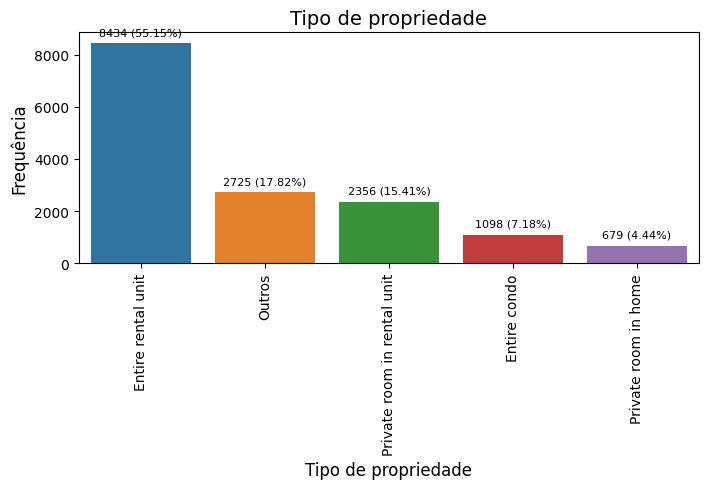

In [51]:
grafico_barra(df_airbnb_listagens['property_type'], 'Tipo de propriedade', 'Tipo de propriedade', 'Frequência', 12, 14, 10, 90, True)

A maior parte dos imóveis alugados é classificado como "Entire ..." (62.33%), indicando que mais da metade dos alugúeis são de prorpiedades inteiras para o locatário, enquanto menos da metade seriam propriedades compartilhadas, provavelmente com os anfitriões.

## **7 Modelo de Previsão de Preço**

### 7.1 Métricas de Avaliação

* CD (coeficiente de determinação): Nos dirá o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor

* MSE (Erro Médio Quadrático): Vamos calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

* MAE (Erro Médio Absoluto): Possui a mesma finalidade do MSE. <br>
-> Quanto menor for o erro, melhor

### 7.2 Escolha dos Modelos de Regressão

Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

1. Random Forest
2. Linear Regression
3. Extra Tree
4. DecisionTree
5. Support Vector Machines
6. Gradient Boosting

In [52]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()
modelo_dt = DecisionTreeRegressor()
modelo_svm = SVR()
modelo_gb = GradientBoostingRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          'DecisionTree': modelo_dt,
          'SupportVectorMachines': modelo_svm,
          'GradientBoosting': modelo_gb,
          }

# Dados reais de preço que queremos obter com o modelo
y = base_airbnb_listagens_cod['price']

# Dados que serão usados para treinar o modelo
X = base_airbnb_listagens_cod.drop('price', axis=1)

Dentro do método `treinar_modelo` há a separação entre dados de teste e dados de validação.<br>
Essa separação é necessária para poder avaliar se o modelo foi capaz ou não de determinar os preços com precisão após seu treinamento

In [53]:
metricas_modelos = treinar_modelos(X, y, modelos)

Demorou 0.55 minutos para treinar os modelos


### 7.3 Análise dos Modelos de Regressão

Vamos visualizar os resultados obtidos por cada modelo:

In [54]:
for metrica in metricas_modelos:
    for nome_modelo, valores in metrica.items():
        print(nome_modelo)
        for metrica, valor in valores.items():
            print(f'\t{metrica}: {valor}')

RandomForest
	CD: 0.44
	MSE: 25642.38
	MAE: 113.9
LinearRegression
	CD: 0.36
	MSE: 29400.92
	MAE: 124.8
ExtraTrees
	CD: 0.39
	MSE: 27836.83
	MAE: 116.97
DecisionTree
	CD: -0.11
	MSE: 50489.09
	MAE: 151.5
SupportVectorMachines
	CD: 0.21
	MSE: 36081.71
	MAE: 127.53
GradientBoosting
	CD: 0.42
	MSE: 26326.57
	MAE: 116.82


Os resultados obtidos não foram satisfatórios.<br>
Com o maior R² = 0.44, é possível afirmar que, embora hajam muitos dados na análise, não é possível precificar um imóvel com base neles com muita precisão.

### 7.4 Tentativa de melhorar o modelo

Aqui, vamos trabalhar com as seguintes pontuações:
1. A vizinhança está implícita nas coordenadas - iremos retirar as colunas de vizinhança da análise
2. Ser um superhost deve influenciar no preço? Julgamos que não é um fator tão relevante - removeremos do modelo
3. Tempo de resposta do host provavelmente não influencia muito no preço - será desconsiderado
4. Será utilizado o log do preço para diminuir a dispersão de valores
5. Como vimos anteriormente, número de banheiros e quantidade de pessoas acomodadas tem uma relação direta, criaremos uma nova coluna que relaciona as duas

In [55]:
df_temp1 = base_airbnb_listagens_cod.copy()

In [56]:
#1
df_temp1 = df_temp1.filter(regex=r'^((?!neighbourhood_cleansed).)*$')
#2
df_temp1 = df_temp1.filter(regex=r'^((?!host_is_superhost).)*$')
#3
df_temp1 = df_temp1.filter(regex=r'^((?!host_response_time).)*$')
#4
df_temp1['price'] = np.log(df_temp1['price'])
#5
df_temp1['bath_accom'] = df_temp1['bathrooms'] * df_temp1['accommodates']

In [57]:
# Dados reais de preço que queremos obter com o modelo
y_ = df_temp1['price']

# Dados que serão usados para treinar o modelo
X_ = df_temp1.drop('price', axis=1)

metricas_modelos = treinar_modelos(X_, y_, modelos)

Demorou 0.43 minutos para treinar os modelos


In [58]:
for metrica in metricas_modelos:
    for nome_modelo, valores in metrica.items():
        print(nome_modelo)
        for metrica, valor in valores.items():
            print(f'\t{metrica}: {valor}')

RandomForest
	CD: 0.53
	MSE: 0.19
	MAE: 0.34
LinearRegression
	CD: 0.4
	MSE: 0.24
	MAE: 0.39
ExtraTrees
	CD: 0.51
	MSE: 0.2
	MAE: 0.34
DecisionTree
	CD: 0.06
	MSE: 0.38
	MAE: 0.47
SupportVectorMachines
	CD: 0.45
	MSE: 0.22
	MAE: 0.37
GradientBoosting
	CD: 0.5
	MSE: 0.2
	MAE: 0.36


Aqui obtemos um melhor resultado para a predição de preços, com erro médio quadrático de 0.19 usando RendomForest (o que seria aproximadamente 1.55 reais)

O Coeficiente de Determinação continuou longe de 1, demonstrando que não é possível criar um modelo linear bom para o preço. 

### 7.5 Prevendo o preço de um imóvel
Vamos agora estimar o preço de uma casa hipotética com o regressor RandomForest

In [59]:
df_casa = pd.DataFrame({'host_response_rate': [1.0], 'host_acceptance_rate': [0.9], 
                        'latitude': [-22.97569], 'longitude': [-43.18824], 'accommodates': [5], 
                        'bathrooms': [2], 'bedrooms': [2], 'beds': [4], 'minimum_nights': [2], 
                        'availability_365': [365], 'instant_bookable': [True], 'calculated_host_listings_count': [1],
                        'property_type_Entire condo': [True], 'property_type_Entire rental unit': [False],	
                        'property_type_Outros': [False], 'property_type_Private room in home': [False],
                        'property_type_Private room in rental unit': [False], 'room_type_Entire home/apt': [True],
                        'room_type_Hotel room': [False], 'room_type_Private room': [False], 'room_type_Shared room': [False],
                        'bath_accom': [10] })

A casa terá as seguiintes características:<br>
Localização: Copacabana<br>
Disponibilidade no ano: 365 dias<br>
Acomoda 5 pessoas<br>
Quartos: 2<br>
Banheiros: 2<br>
Mínimo de noites: 2<br>
Disponibilidade instantânea<br>
Tipo de propriedade: Apartamento completo<br>
Tipo de quarto: Casa/Apto completo<br>
Quantidade de listagens do host: 1<br>
Taxa de resposta do host: 100%<br>
Taxa de aceitaÇão do host: 90%<br>

Vamos calcular a diária para essa casa:


In [60]:
modelo_rf = RandomForestRegressor()
#treinar
modelo_rf.fit(X_, y_)
#testar
previsao = modelo_rf.predict(df_casa)
print(f'Preço da casa calculado: R${np.exp(previsao[0]):.2f}')

Preço da casa calculado: R$482.35


# 7.6 Teste de Hipoteses

## Hipotese: O brasileiro médio consegue alugar um imóvel médio

In [61]:
import pandas as pd
from scipy import stats

salario_medio_brasileiro = 2569
precos_imoveis = base_airbnb_listagens_cod['price']
media_precos_imoveis = precos_imoveis.mean()

t_statistic, p_value = stats.ttest_1samp(precos_imoveis, salario_medio_brasileiro)

print('Média dos preços dos imóveis:', media_precos_imoveis)
print('Estatística t:', t_statistic)
print('Valor p:', p_value)

nivel_de_significancia = 0.05
if p_value < nivel_de_significancia:
    print('Rejeitar a hipótese nula - Há evidências para suportar a hipótese alternativa')
else:
    print('Não rejeitar a hipótese nula - Não há evidências para suportar a hipótese alternativa')

Média dos preços dos imóveis: 334.6889877059901
Estatística t: -1283.8483971347487
Valor p: 0.0
Rejeitar a hipótese nula - Há evidências para suportar a hipótese alternativa


##### Hipótese nula (H0): O brasileiro médio consegue alugar um imóvel médio.
##### Hipótese alternativa (Ha): O brasileiro médio não consegue alugar um imóvel médio.

## Hipotese: Anfitriões com tempo de resposta mais rápido têm maior taxa de ocupação

In [62]:
import pandas as pd
import statsmodels.api as sm

dados = base_airbnb_listagens_cod

dummies = pd.get_dummies(dados[['host_response_time_a few days or more', 'host_response_time_within a day',
                               'host_response_time_within a few hours', 'host_response_time_within an hour']],
                         drop_first=True)

X = sm.add_constant(dummies)
y = dados['availability_365']

modelo = sm.OLS(y, X)
resultado = modelo.fit()
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:       availability_365   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     117.7
Date:                Sun, 04 Jun 2023   Prob (F-statistic):           2.28e-75
Time:                        22:34:41   Log-Likelihood:                -96094.
No. Observations:               15292   AIC:                         1.922e+05
Df Residuals:                   15288   BIC:                         1.922e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

##### Analisando os resultados chegamos as seguintes conclusões: 
###### o tempo de resposta é uma fator que tem influencia na taxa de locação do imovel, porem apenas tempo de resposta não é um fator decisivo para prever a locação, isso sendo comprovado pelo valor do R^2 e a conclusão mais importante é dada pelos valores dos coeficientes, demostrando que quanto maior o tempo de resposta, maior o coeficiente, resultando em um tempo maior do imovel vago, logo, quanto mais rapido o locatario responde, mais rapido ele tem seu imovel locado.